# Capstone Project: Malacious URL detection using Machine Learning and Artificial Intelligence


### Business Understanding

**Overview**: The Web has long become a major platform for online criminal activities. URLs are used as the main vehicle in this domain. To counter this issues security community focused its efforts on developing techniques for mostly blacklisting of malicious URLs. While successful in protecting users from known malicious domains, this approach only solves part of the problem. The new malicious URLs that sprang up all over the web in masses commonly get a head start in this race. . In this project I explored a lightweight approach to detection and categorization of the malicious URLs according to their attack type and show that lexical analysis is effective and efficient for proactive detection of these URLs.



### Data Understanding
#### Dataset Overview¶
This dataset has been created by combining a number of a different datasets together such as ISCx-URL2016,faizan git repo and from bad URL reporting sites such as PhishTank.

#### Collect Initial Data
The dataset consists of 651,191 URLs, out of which 428103 benign or safe URLs, 96457 defacement URLs, 94111 phishing URLs, and 32520 malware URLs. It has two columns comprising of url and a type which signifies the class of maliciousness

#### Describe Data

The data represents 17 marketing campaigns occured between May 2008 and Nov 2010, corresponding to a total of 79354 contacts.

#### Read in the Data

Use pandas to read in the dataset `malicious_phish.csv`.

In [45]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"
import time
import warnings
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld


# Ignore warnings
warnings.filterwarnings('ignore')

In [46]:
#Collect Initial Data
df = pd.read_csv('../data/malicious_phish.csv')


In [47]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [48]:
df.shape

(651191, 2)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [50]:
df.describe

<bound method NDFrame.describe of                                                       url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://www.garage-pirenne.be/index.php?option=...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188         www.gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]>

Understanding the Features

1. url-type of urls
2. type -type of urls ['benign', 'defacement', 'phishing', 'malware]

###  Explore & Verify data 
The dataset dosen't contain null values
1. Check for Null values: No null values found 
2. Determine the unique values for each columns

In [51]:
#Checking for NaN values
df.isnull().sum()

url     0
type    0
dtype: int64

In [52]:
# Describe data
df.describe(include = ['object'])

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [53]:
#Explore and verify data
count = df.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [54]:
x=count.index
x

Index(['benign', 'defacement', 'phishing', 'malware'], dtype='object')

#### Extract and prepare data

Removing www from the URL

In [56]:
#Extract data
df['url'] = df['url'].replace('www.', '', regex=True)
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [57]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


### Data Preparation

After my initial exploration and fine tuning of the dataset, it is time to prepare,extract data  prior to modeling

#### Feature Engineering

In [58]:
#Extracting category from URL type
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
df['Category'] = df['type']
df = df.replace(rem)
df.head(5)

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [59]:
#Create a seperate column with lenght of URL
df['url_len'] = df['url'].apply(lambda x: len(str(x)))
df.head(5)


,url,type,Category,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235


Extract and create column domain


In [60]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
df['domain'] = df['url'].apply(lambda i: process_tld(i))
df.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


Extract and create columns using special characters

In [61]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    df[a] = df['url'].apply(lambda i: i.count(a))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [62]:
# urlparse():This function parses a URL into six components, returning a 6-tuple. 
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1


Extract secure URL

In [63]:
def httpSecure(url):
    htp = urlparse(url).scheme #It supports the following URL schemes: file , ftp , gopher , hdl , 
                               #http , https ... from urllib.parse
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['https'] = df['url'].apply(lambda i: httpSecure(i))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1,0


Counts the number of digit characters in a URL

In [64]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['digits']= df['url'].apply(lambda i: digit_count(i))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,%,+,$,!,*,",",//,abnormal_url,https,digits
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,0,1,1,0,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,0,1,1,0,22


Counts the number of letter characters in a URL

In [65]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['letters']= df['url'].apply(lambda i: letter_count(i))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,+,$,!,*,",",//,abnormal_url,https,digits,letters
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,25
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,1,1,0,7,60
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,1,1,0,22,199


Checks to see whether URL contains a shortening service

In [69]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['Shortining_Service'] = df['url'].apply(lambda x: Shortining_Service(x))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,1,1,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,1,1,0,22,199,0


Data Visulization

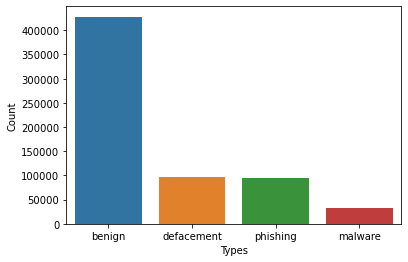

In [80]:
# URL type count plot
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');
plt.savefig("images/url_type_count")
plt.show()

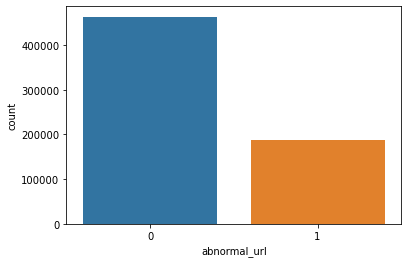

In [81]:
# abnormal_url plot
sns.countplot(x='abnormal_url', data=df);
plt.savefig("images/abnormal_url")
plt.show()


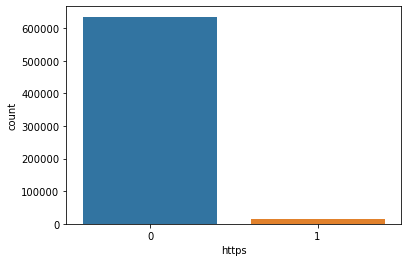

In [82]:
#https count
sns.countplot(x='https', data=df);
plt.savefig("images/https")
plt.show()

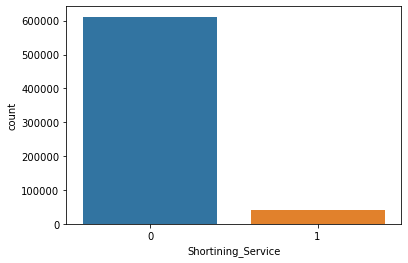

In [83]:
#Shortining_Service plot
sns.countplot(x='Shortining_Service', data=df);
plt.savefig("images/shortining_service")
plt.show()

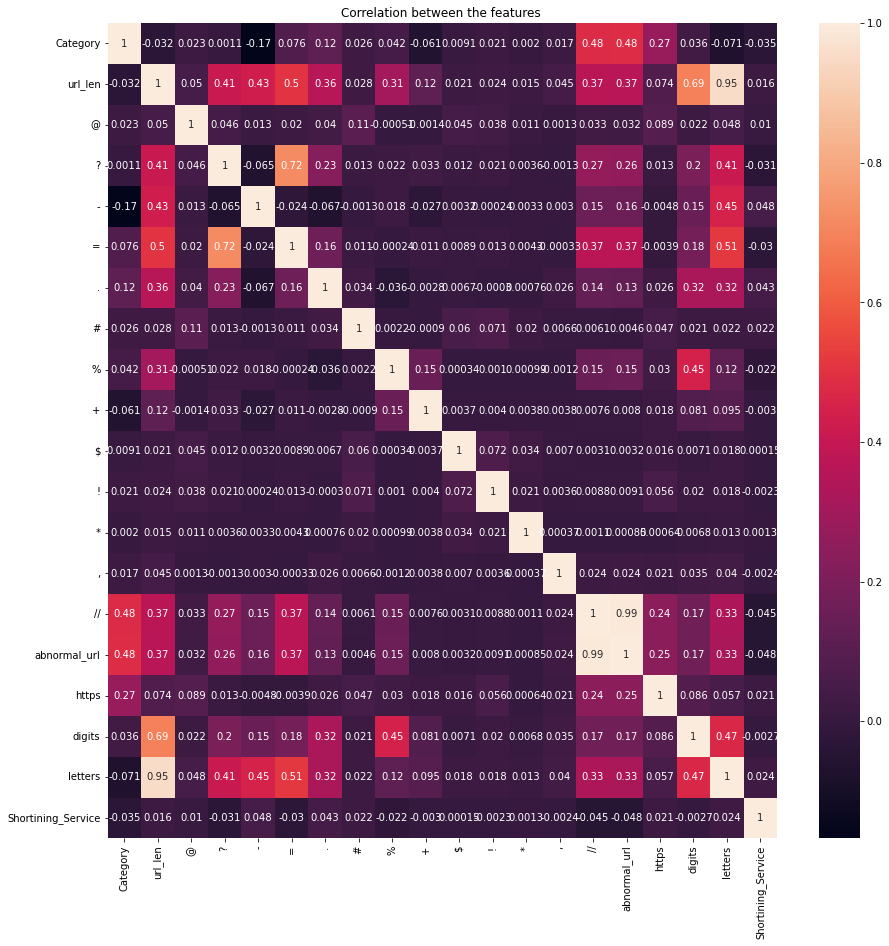

In [86]:
#Describe data and visualize it
df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation between the features ')
plt.savefig("images/feature_corr")
plt.show()

In [88]:
 #Describe data and visualize it
category_features = df.columns.values
# Visualize categorical features of the dataset
for col in category_features:
    plt.figure(figsize=(10,5))    
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index, data=df)    
    plt.title(col)    
    plt.tight_layout()
    plt.savefig("images/"+col)

Inference:


Inference
The campaign was more effective during summer months and dipped during other spring and fall holidays

###  Train/Test Split

With your data prepared, split it into a train and test set.

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 22)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify = y, random_state=22)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)


Number transactions X_train dataset:  (28794, 11)
Number transactions y_train dataset:  (28794,)
Number transactions X_test dataset:  (12341, 11)
Number transactions y_test dataset:  (12341,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Using dummy classifier as Baseline model as it's  a type of classifier which does not generate any insight about the data and classifies the given data using only simple rules. The classifier’s behavior is completely independent of the training data as the trends in the training data are completely ignored and instead uses one of the strategies to predict the class label.
Below are a few strategies used by the dummy classifier to predict a class label –
* Most Frequent: The classifier always predicts the most frequent class label in the training data.
* Stratified: It generates predictions by respecting the class distribution of the training data. It is different from the “most frequent” strategy as it instead associates a probability with each data point of being the most frequent class label.
* Uniform: It generates predictions uniformly at random.
* Constant: The classifier always predicts a constant label and is primarily used when classifying non-majority class labels.

In [ ]:
# Instantiate a dummy classifier that always predicts the majority class
strategies = ['most_frequent', 'stratified', 'uniform']
  
test_scores = []
for s in strategies:
    
    dummy = DummyClassifier(strategy = s)
  
    # Fit the classifier on the training data
    dummy.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    accuracy = dummy.score(X_test, y_test)
    print("Strategies",s)
    # Print the baseline accuracy
    print("Baseline accuracy: {:.2f}".format(accuracy))
    

Strategies most_frequent
Baseline accuracy: 0.89
Strategies stratified
Baseline accuracy: 0.80
Strategies uniform
Baseline accuracy: 0.50


### Modeling

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

Define the storage dataframe.

In [ ]:
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Name', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

In [ ]:
%%time
# Define the search space for Logistic Regression
log_reg_params = {'solver': ['liblinear', 'lbfgs'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100], 'class_weight': [None, 'balanced']}
log_reg_model=""
# Grid search for Logistic Regression
log_reg_model = GridSearchCV(LogisticRegression(), log_reg_params, cv=5)
log_reg_model.fit(X_train, y_train)

log_reg_best_params = log_reg_model.best_params_


# Evaluate the logistic regression model on the train data
train_accuracy = log_reg_model.score(X_train, y_train)
test_accuracy = log_reg_model.score(X_test, y_test)
# Print the train  accuracy
print("Train accuracy: {:.2f}".format(train_accuracy))

print("Test accuracy: {:.2f}".format(test_accuracy))

Train accuracy: 0.90
Test accuracy: 0.90
CPU times: total: 1min 41s
Wall time: 18.2 s


In [ ]:
%%time
# Selected parameters assignement
log_reg_params = {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
start_time = time.time()
log_reg_model= LogisticRegression(**log_reg_params)
log_reg_model.fit(X_train,y_train)
end_time = time.time()
train_time = end_time - start_time
# Evaluate the logistic regression model on the train data
train_accuracy = log_reg_model.score(X_train, y_train)
test_accuracy = log_reg_model.score(X_test, y_test)

log_reg_model_result = pd.DataFrame({'Name': ['Logistic Regression'], 'Train Time': [train_time], 'Train Accuracy': [train_accuracy], 'Test Accuracy': [test_accuracy]})
results_df = pd.concat([results_df, log_reg_model_result])
# Print the train  accuracy
print("Train accuracy: {:.2f}".format(train_accuracy))
print("Test accuracy: {:.2f}".format(test_accuracy))

Train accuracy: 0.90
Test accuracy: 0.90
CPU times: total: 1 s
Wall time: 235 ms


Inference: Evem with different LogisticRegression parameter I got same accuracy of 0.90

### Problem 9: Score the Model

What is the accuracy of your model?

#### Logistic Regression Model

In [ ]:
# Evaluate the logistic regression model on the test data for solver='sag',max_iter=10000
accuracy = log_reg_model.score(X_test, y_test)

# Print the test accuracy
print("Test accuracy: {:.2f}".format(accuracy))


# Evaluate the logistic regression model on the test data solver='liblinear'
accuracy = log_reg_model.score(X_test, y_test)

# Print the test accuracy
print("Test accuracy: {:.2f}".format(accuracy))

Test accuracy: 0.90
Test accuracy: 0.90


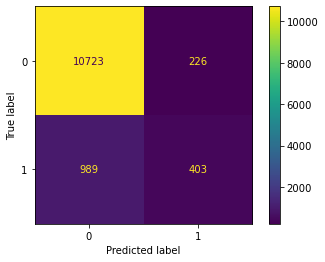

In [ ]:
# Make predictions on the test data for LogRegModel
y_pred = log_reg_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a confusion matrix display
cmd = ConfusionMatrixDisplay(cm, display_labels=log_reg_model.classes_)

# Plot the confusion matrix
cmd.plot()

In [ ]:
# Make predictions on the test data
y_pred = log_reg_model.predict(X_test)


# Calculate the precision, recall, and F1 score
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Print the performance metrics
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))

# Print the test accuracy
print("Test accuracy: {:.2f}".format(accuracy))

Precision: 0.641
Recall: 0.290
F1 Score: 0.399
Test accuracy: 0.90


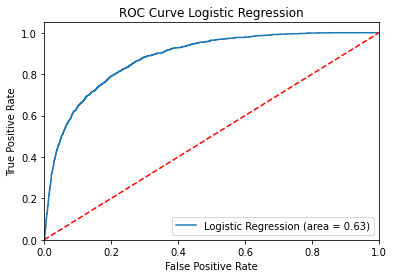

Logistic Regression AUC Score: 0.88


In [ ]:
#AUC ROC curve  for LogRegModel
logit_roc_auc = roc_auc_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test, log_reg_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_Logistic Regression')
plt.show()
auc_score =roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:,1])
print("Logistic Regression AUC Score: {:.2f}".format(auc_score))

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:



In [ ]:
# prepare configuration for cross validation test harness
seed = 7
cv_results =[]
# prepare models
models = []
# Model parameters
log_reg_params = {'solver': 'liblinear', 'C': 1.0, 'penalty': 'l2', 'class_weight': 'balanced'}
dec_tree_params = {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}
knn_params = {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 30}
svm_params = {'C': 1.0, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'class_weight': 'balanced'}

In [ ]:
%%time
# Fit the LogisticRegression models
log_reg = LogisticRegression(**log_reg_params)
log_reg.fit(X_train, y_train)
y_pred =log_reg.predict(X_test)
# computing and plotting confusion matrix
c_m = confusion_matrix(y_test, y_pred)
print('LogisticRegression:\n confusion matrix\n', c_m,'\n\n')
models.append(('LogisticRegression',log_reg))

LogisticRegression:
 confusion matrix
 [[9227 1722]
 [ 371 1021]] 


CPU times: total: 609 ms
Wall time: 118 ms


In [ ]:
%%time
# Fit the DecisionTreeClassifier models
dec_tree = DecisionTreeClassifier(**dec_tree_params)
dec_tree.fit(X_train, y_train)
y_pred =dec_tree.predict(X_test)
# computing and plotting confusion matrix
c_m = confusion_matrix(y_test, y_pred)
print('DecisionTreeClassifier:\n confusion matrix\n', c_m,'\n\n')
models.append(('DecisionTreeClassifier',dec_tree))

DecisionTreeClassifier:
 confusion matrix
 [[10684   265]
 [  918   474]] 


CPU times: total: 109 ms
Wall time: 39 ms


In [ ]:
%%time
# Fit the KNeighborsClassifier models
knn = KNeighborsClassifier(**knn_params)
knn.fit(X_train, y_train)
y_pred =knn.predict(X_test)
# computing and plotting confusion matrix
c_m = confusion_matrix(y_test, y_pred)
print('KNeighborsClassifier:\n confusion matrix\n', c_m,'\n\n')
models.append(('KNeighborsClassifier',knn))

KNeighborsClassifier:
 confusion matrix
 [[10608   341]
 [  996   396]] 


CPU times: total: 703 ms
Wall time: 707 ms


In [ ]:
%%time
# Fit the SVC models
svm = SVC(**svm_params)
svm.fit(X_train, y_train)
y_pred =svm.predict(X_test)
# computing and plotting confusion matrix
c_m = confusion_matrix(y_test, y_pred)
print('SVC:\n confusion matrix\n', c_m,'\n\n')
models.append(('SVC',svm))


SVC:
 confusion matrix
 [[9010 1939]
 [ 282 1110]] 


CPU times: total: 43.1 s
Wall time: 43.2 s


LogisticRegression: 0.819254 (0.052958)
[0.85571897 0.85438191 0.84939832 0.82022608 0.71654309]:
DecisionTreeClassifier: 0.886520 (0.016776)
[0.88720068 0.89096876 0.90044974 0.89947733 0.85450346]:
KNeighborsClassifier: 0.879956 (0.014299)
[0.89716786 0.88756533 0.88233864 0.87844901 0.85426036]:
SVC: 0.809748 (0.050522)
[0.84332077 0.83833718 0.8410113  0.81536405 0.71070864]:


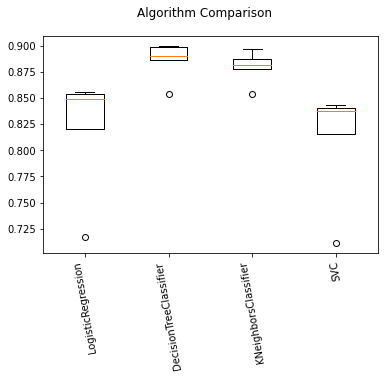

In [ ]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
kfold=10
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=5, scoring='accuracy')
   
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print("%s:" % cv_results)
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.tick_params(axis='x', labelrotation = 100)
plt.savefig("images/algorithmcomparision")
plt.show()

Conclusion: Decison Tree is the best model for Portuguese bank direct marketing data mining project

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

2nd attempt at comparing Models by tweaking parameter and using othe hyperparameters

In [ ]:
# Define the search space for Decision Tree
dec_tree_params ={'max_depth': [1,2, 3, 4, 5, 6, 7, 8, 9, 10],
         'min_samples_split': [0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [1,2, 3, 4, 5, 6, 7, 8, 9, 10],
         }

# Define the search space for KNN

knn_params = {'model__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],'gamma': [0.1, 1.0, 10.0, 100.0]}

# Define the search space for SVM

svm_params =  {
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}



Decision Tree Model

In [ ]:
%%time
# Grid search for Decision Tree this is model is too slow please uncomment and run to see in action 
start_time = time.time()
#grid_GridSearchCV = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid=dec_tree_params).fit(X_train, y_train)
#end_time = time.time()
#train_time = end_time - start_time
#train_accuracy = grid_GridSearchCV.score(X_train, y_train)
#test_accuracy = grid_GridSearchCV.score(X_test, y_test)
#grid_GridSearchCV_best_params = grid_GridSearchCV.best_params_
#print(f'GridSearchCV Training Accuracy: {train_accuracy: .2f}')
#print(f'GridSearchCV Test Accuracy: {test_accuracy: .2f}')
#print(f'GridSearchCV Best parameters of tree: {grid_GridSearchCV_best_params}')




CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
start_time = time.time()
#dec_tree_model = DecisionTreeClassifier(random_state=42)
dec_tree_model.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time

train_accuracy = dec_tree_model.score(X_train, y_train)
test_accuracy = dec_tree_model.score(X_test, y_test)
print("Train accuracy: {:.2f}".format(train_accuracy))
print("Test accuracy: {:.2f}".format(test_accuracy))

dec_tree_model_results = pd.DataFrame({'Name': ['Decision Tree'], 'Train Time': [train_time], 'Train Accuracy': [train_accuracy], 'Test Accuracy': [test_accuracy]})
results_df = pd.concat([results_df, dec_tree_model_results])

Train accuracy: 1.00
Test accuracy: 0.86
CPU times: total: 156 ms
Wall time: 156 ms


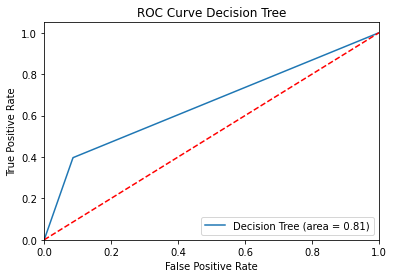

Decision Tree  AUC Score: 0.66


In [ ]:
#AUC ROC curve  for LogRegModel
logit_roc_auc = roc_auc_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test, dec_tree_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Decision Tree')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_DecisionTree')
plt.show()
auc_score =roc_auc_score(y_test, dec_tree_model.predict_proba(X_test)[:,1])
print("Decision Tree  AUC Score: {:.2f}".format(auc_score))

KNN Model

In [ ]:
 %%time
 from sklearn.model_selection import cross_val_score

# Fit and time the KNN model

start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8844502066283121
CPU times: total: 1.03 s
Wall time: 1.04 s


In [ ]:
#Using Cross Validation to Get the Best Value of k
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

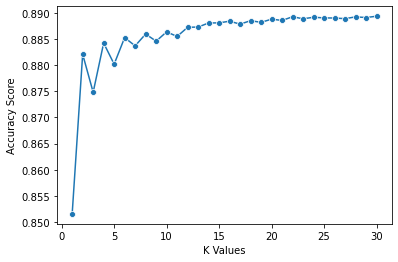

In [ ]:
#We can plot the results with the following code
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.savefig('images/KValues')

In [ ]:
 %%time
#We can now train our model using the best k value using the code below.
best_index = np.argmax(scores)
best_k = k_values[best_index]
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
end_time = time.time()
train_time = end_time - start_time
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)
print("Train accuracy: {:.2f}".format(train_accuracy))
print("Test accuracy: {:.2f}".format(test_accuracy))
knn_results = pd.DataFrame({'Name': ['KNN'], 'Train Time': [train_time], 'Train Accuracy': [train_accuracy], 'Test Accuracy': [test_accuracy]})
results_df = pd.concat([results_df, knn_results])


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Train accuracy: 0.90
Test accuracy: 0.89
Accuracy: 0.893444615509278
Precision: 0.582089552238806
Recall: 0.1961206896551724
CPU times: total: 4.05 s
Wall time: 4.07 s


[[  273  1119]
 [  196 10753]]


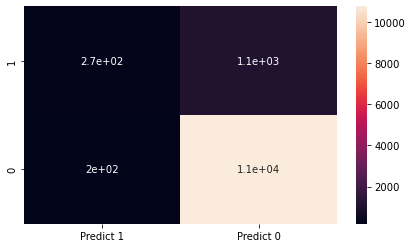

In [ ]:
ConfMat=confusion_matrix(y_test, y_pred, labels=[1, 0])
print (ConfMat)

ConfMat_DF = pd.DataFrame(ConfMat, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,4))
sns.heatmap(ConfMat_DF, annot=True )
plt.savefig('images/conf1')

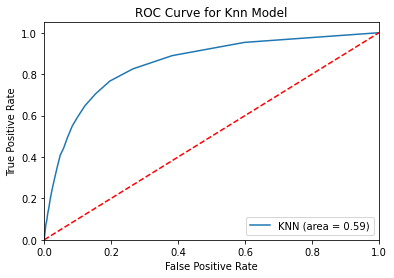

KNN AUC Score: 0.8505980050663315


In [ ]:
knn_roc_auc = roc_auc_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Knn Model')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_KNN')
plt.show()
auc_score = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
print("KNN AUC Score:",auc_score)

SVC Model

In [ ]:
 %%time
# Fit and time the SVM model

start_time = time.time()
svc=SVC(C= .1, kernel='rbf', gamma= 'auto',probability=True)
svc.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time
y_pred = svc.predict(X_test)
train_accuracy = svc.score(X_train, y_train)
test_accuracy = svc.score(X_test, y_test)
print("Train accuracy: {:.2f}".format(train_accuracy))
print("Test accuracy: {:.2f}".format(test_accuracy))
svc_results = pd.DataFrame({'Name': ['SVC'], 'Train Time': [train_time], 'Train Accuracy': [train_accuracy], 'Test Accuracy': [test_accuracy]})
results_df = pd.concat([results_df, svc_results], ignore_index=False)

Train accuracy: 0.89
Test accuracy: 0.89
CPU times: total: 3min 23s
Wall time: 3min 23s


[[    1  1391]
 [    1 10948]]


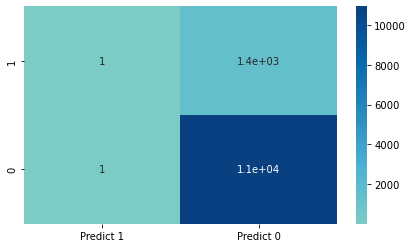

In [ ]:
ConfMat=confusion_matrix(y_test, y_pred, labels=[1, 0])
print (ConfMat)

ConfMat_DF = pd.DataFrame(ConfMat, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,4))
sns.heatmap(ConfMat_DF, annot=True, cmap='GnBu',center=0 )
plt.savefig('images/conf2')

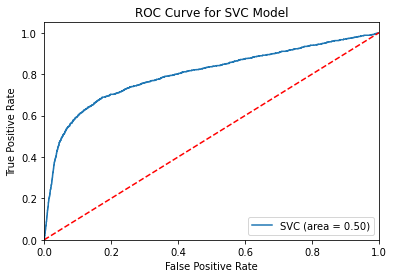

KNN AUC Score: 0.8009840950152378


In [ ]:
svc_roc_auc = roc_auc_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % svc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVC Model')
plt.legend(loc="lower right")
plt.savefig('images/KNN_ROCSVC')
plt.show()
auc_score = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])
print("KNN AUC Score:",auc_score)

Model Result Comparision

In [ ]:
results_df

,Name,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.225516,0.902653,0.901548
0,Decision Tree,0.131996,0.999826,0.855684
0,KNN,0.997737,0.899215,0.893445
0,SVC,155.948212,0.887372,0.887205


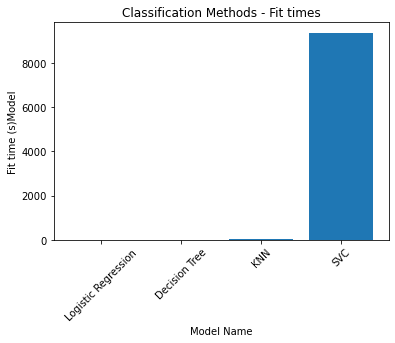

In [ ]:
plt.bar(results_df['Name'], results_df['Train Time'])
plt.xlabel('Model Name')
plt.ylabel('Fit time (s)Model')
plt.title("Classification Methods - Fit times")
plt.xticks(rotation=45)
plt.savefig('images/TrainTime')
plt.show()

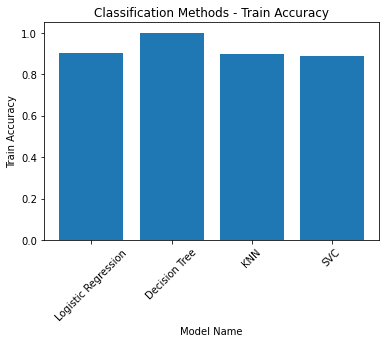

In [ ]:
plt.bar(results_df['Name'], results_df['Train Accuracy'])
plt.xlabel('Model Name')
plt.ylabel('Train Accuracy')
plt.title("Classification Methods - Train Accuracy")
plt.xticks(rotation=45)
plt.savefig('images/TrainAccuracy')
plt.show()

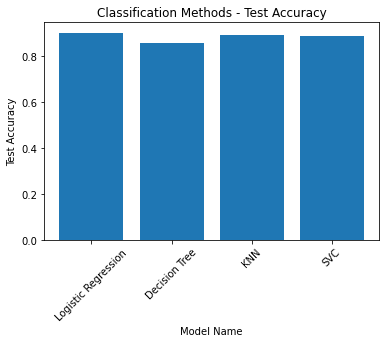

In [ ]:
plt.bar(results_df['Name'], results_df['Test Accuracy'])
plt.xlabel('Model Name')
plt.ylabel('Test Accuracy')
plt.title("Classification Methods - Test Accuracy")
plt.xticks(rotation=45)
plt.savefig('images/TestAccuracy')
plt.show()

Concusion: Decison Tree is the best model for Portuguese bank direct marketing data mining project followed by Logistic Regression.


##### Questions
It would be worth while to try other model I learnt in this course, due to lack of time I couldn't explore it. 